In [2]:
# general
import pandas as pd
import numpy as np
from collections import Counter

# plotting
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
def read_fasta(file_path):
    with open(file_path, 'r') as file:
        sequences = [line.strip() for line in file if not line.startswith(">")]
    return pd.DataFrame(sequences, columns=["Sequence"])

In [4]:
bound = read_fasta('/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_2/max_bound.fasta')
bound

,Sequence
0,AGAGCAAGTGTAAGTTCTTAGGCGCTCGAG
1,ACAGAATTAACTGCGGGCATCGCAAACCTG
2,GTTAACTCTGCATAACTCATTTTAGATGTT
3,TCCTGAATCTCGTCTGGACTAGGGACACTT
4,GAGCAAAAGGAAACTCAAAACATTGCTTCG
...,...
1995,TAGCATTGTCAACCTTGTGAGTACAGCGAC
1996,TATTAGGGATGGACACGTGCAATAACTGCC
1997,AAAATGATTTAAGCCGGAAGAGTAAGGTGA
1998,CAGACAGGCGTGCCACCAGCCGAAGTGCTG


In [5]:
unbound = read_fasta('/Users/peytonhall/Documents/spring_2025/qbio_465/assignment_2/max_unbound.fasta')
unbound

,Sequence
0,TCAACTTAGAGGGCACGTGGCGATCATATA
1,TACAGACTAGATTCACCCGAATAGTACCGA
2,CCATGCACTAAACCAGGTGTACGCTGAGAG
3,TGTCGACGTCAATCACGAGGGAGAGATACT
4,TCCAATAATAGGGCACACGGATAAAGGGGG
...,...
1995,ACCCGAGATCAGTCACGTGAACACAAAAAT
1996,ATATACCCCCAGGCACGTGGCATCGAGGTT
1997,TGGGGTATGTAACCAAGGGTCTAATGATGA
1998,TTAGGGCAGCAACCACGTGAGTCAACGATC


Q1: Visualizing Nucleotide and Dinucleotide Composition [1 pts]
1. Count the occurrences of each nucleotide (A, C, G, T) and dinucleotide (AA, AC, ..., TT)
in bound and unbound sequences for MAX.
2. Create bar plots comparing nucleotide and dinucleotide distributions between bound and
unbound sequences.
3. Briefly interpret differences in sequence composition between bound and unbound
sequences. Discuss your findings and possible explanations for the observations.

In [6]:
def count_tide(data, k):
    counts = Counter()
    #iterate
    for seq in data:  
        for i in range(len(seq) - k + 1):
            counts[seq[i:i+k]] += 1
    return pd.DataFrame(counts.items(), columns=["K-mer", "Count"]).sort_values(by="Count", ascending=False)

In [7]:
print(bound.iloc[:, 0])

0       AGAGCAAGTGTAAGTTCTTAGGCGCTCGAG
1       ACAGAATTAACTGCGGGCATCGCAAACCTG
2       GTTAACTCTGCATAACTCATTTTAGATGTT
3       TCCTGAATCTCGTCTGGACTAGGGACACTT
4       GAGCAAAAGGAAACTCAAAACATTGCTTCG
                     ...              
1995    TAGCATTGTCAACCTTGTGAGTACAGCGAC
1996    TATTAGGGATGGACACGTGCAATAACTGCC
1997    AAAATGATTTAAGCCGGAAGAGTAAGGTGA
1998    CAGACAGGCGTGCCACCAGCCGAAGTGCTG
1999    TCACTCCCCCACATCTGGGTATCAACACAC
Name: Sequence, Length: 2000, dtype: object


In [8]:
# apply to mono
bound_mono = count_tide(bound.iloc[:,0], 1)
bound_mono["Count"] = bound_mono["Count"] / 2000

unbound_mono = count_tide(unbound.iloc[:,0], 1)
unbound_mono["Count"] = unbound_mono["Count"] / 2000

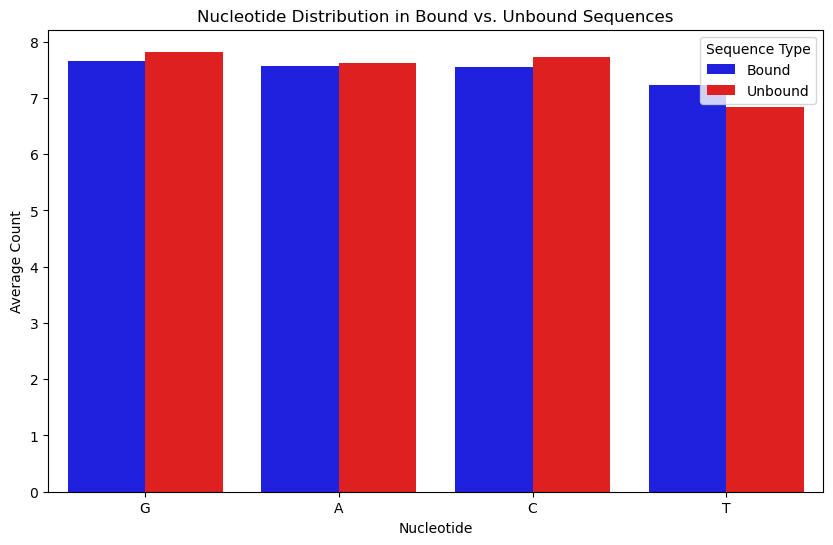

In [9]:
# combine the dfs
bound_mono["Type"] = "Bound"  
unbound_mono["Type"] = "Unbound"  
combined_mono = pd.concat([bound_mono, unbound_mono])

# plot
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_mono, x="K-mer", y="Count", hue="Type", palette=["blue", "red"])
plt.xlabel("Nucleotide")
plt.ylabel("Average Count")
plt.title("Nucleotide Distribution in Bound vs. Unbound Sequences")
plt.legend(title="Sequence Type")
plt.show()

In [10]:
bound_di = count_tide(bound.iloc[:,0], 2)
bound_di["Count"] = bound_di["Count"] / 2000

unbound_di = count_tide(unbound.iloc[:,0], 2)
unbound_di["Count"] = unbound_di["Count"] / 2000

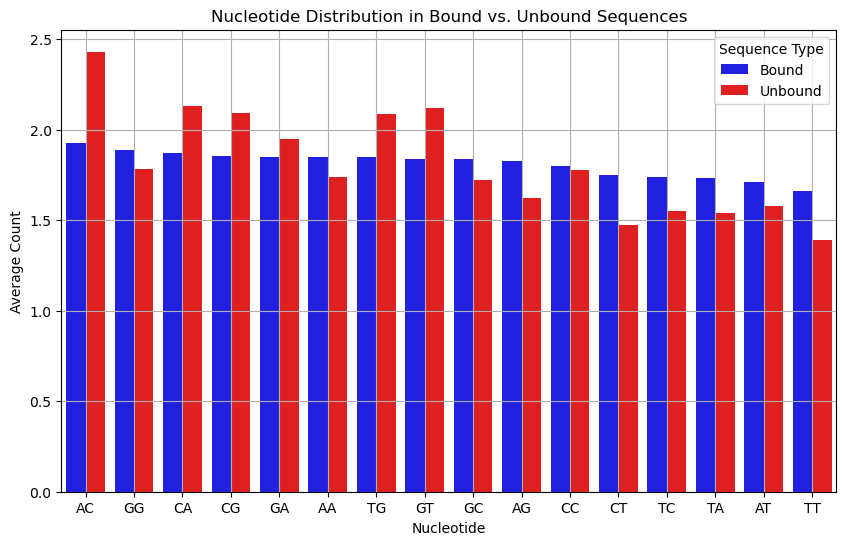

In [12]:
# combine the dfs
bound_di["Type"] = "Bound"  
unbound_di["Type"] = "Unbound"  
combined_di = pd.concat([bound_di, unbound_di])

# plot
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_di, x="K-mer", y="Count", hue="Type", palette=["blue", "red"])
plt.xlabel("Nucleotide")
plt.ylabel("Average Count")
plt.grid()
plt.title("Nucleotide Distribution in Bound vs. Unbound Sequences")
plt.legend(title="Sequence Type")
plt.show()

Q2: Logistic Regression with L1 Regularization [2 pts]
1. Implement a logistic regression model to classify sequences as bound or unbound.
2. Choose an appropriate regularization method (L1, L2, or Elastic Net) and justify your
choice.
3. Use 10-fold cross-validation for training and validation.
4. Ensure the data is shuffled and stratified across folds.
5. Plot the training and validation accuracy for each fold. Discuss your observations.

In [13]:
# need to encode
def encodeMono(sequence):
    monoMap = {"A": [1, 0, 0, 0], "C": [0, 1, 0, 0], "G": [0, 0, 1, 0], "T": [0, 0, 0, 1]}
    encoded = []
    for mononucleotide in sequence:
        encoded.extend(monoMap[mononucleotide])
    return encoded

In [14]:
labels = ['Bound'] * len(bound) + ['Unbound'] * len(unbound)
labels_series = pd.Series(labels)

In [15]:
sequences = pd.concat([bound.iloc[:, 0], unbound.iloc[:, 0]])
# encodeMono 
encoded_sequences = [encodeMono(seq) for seq in sequences]

In [16]:
encoded_df = pd.DataFrame(encoded_sequences)
# X_train, X_test, y_train, y_test = train_test_split(encoded_array, labels, test_size=0.2, random_state=42, stratify=labels)

In [17]:
def log_regression(encoded_df, labels):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(encoded_df, labels, test_size=0.2, random_state=42, stratify=labels)
    
    model = LogisticRegression(penalty='l1', solver='liblinear')

    # prep for cv
    # 10-fold cross-validation for training and validation
    # Ensure the data is shuffled and stratified 
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    train_accuracies = []
    val_accuracies = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]  

        model.fit(X_train_fold, y_train_fold)

        train_pred = model.predict(X_train_fold)
        val_pred = model.predict(X_val_fold)

        train_accuracies.append(accuracy_score(y_train_fold, train_pred))
        val_accuracies.append(accuracy_score(y_val_fold, val_pred))
    
    return model, train_accuracies, val_accuracies

In [18]:
model, train_accuracies,val_accuracies = log_regression(encoded_df, labels_series)

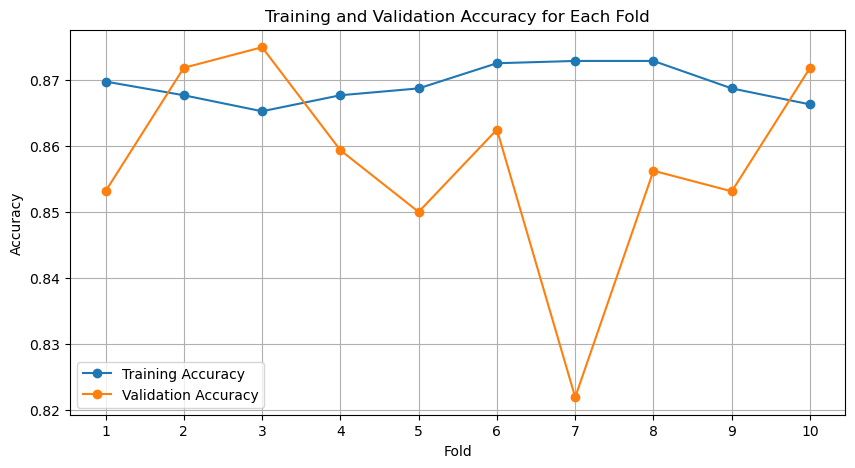

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, 11), val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Each Fold')
plt.xticks(range(1, 11))
plt.legend()
plt.grid()
plt.show()

I chose L1 for this logistic regression model to classify sequences as bound or unbound because it effectively handles feature selection by mitigating less important features/noise. This is  beneficial in high-dimensional datasets, like nucleotide and dinucleotide distributions, where many sequences might not really contribute  to the model's predictive power. 

After plotting traiining and validation accuracies, it seems 2 or 3 folds performs the best with improved validation accuracies. As folds increase past this point, overfitting seems to be more prominent, with a strong overfitting around 7 folds where validation accuracy drops dramatically. 

Q3: Model Evaluation Using AUROC [2 pts]
1. Compute the Area Under the ROC Curve (AUROC) for each fold.
2. Report:
○ The average AUROC and its standard deviation across all folds.
○ A ROC curve plot, showing the mean ROC curve and standard deviation across
folds. Highlight the standard deviation using plt.fill_between().

In [23]:
def evaluate_roc_auc(encoded_df, labels, n_splits=10):
    # labels to binary
    labels = np.array([1 if label == "Bound" else 0 for label in labels])

    # split in di middle 
    X_train, _, y_train, _ = train_test_split(encoded_df, labels, test_size=0.2, random_state=42, stratify=labels)

    # cv
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs = []
    # false positiive rates
    mean_fpr = np.linspace(0,1,100)
    # store true positive
    tprs = []
    
    # initialize 
    model = LogisticRegression(penalty='l1', solver='liblinear')

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_val_prob = model.predict_proba(X_val_fold)[:, 1]  

        # auroc
        auc = roc_auc_score(y_val_fold, y_val_prob)
        aucs.append(auc)
        
        # roc
        fpr, tpr, _ = roc_curve(y_val_fold, y_val_prob)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)  # Interpolate TPRs for consistent plotting
        tprs.append(tpr_interp)

    # avg and stdev 
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    return mean_auc, std_auc, mean_fpr, tprs

In [24]:
def plot_roc_curve(mean_fpr, tprs):
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)

    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC Curve')
    
    # stdev area
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='blue', alpha=0.2, label='± 1 std. dev.')
    
    # ref line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Mean ROC Curve with Standard Deviation')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

Average AUROC: 0.93, Standard Deviation: 0.01


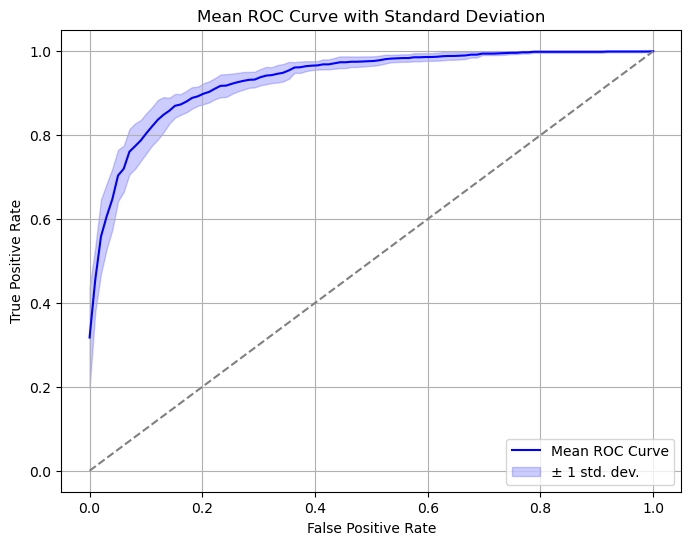

In [25]:
# compute AUROC stats
mean_auc, std_auc, mean_fpr, tprs = evaluate_roc_auc(encoded_df, labels)
print(f"Average AUROC: {mean_auc:.2f}, Standard Deviation: {std_auc:.2f}")

# ROC curve plot
plot_roc_curve(mean_fpr, tprs)

Q4: Feature Importance Analysis [2 pts]
1. Analyze the logistic regression coefficients to determine which positions in the DNA
sequence contribute most to binding predictions.
2. Generate a plot showing the contribution of each base pair position.
3. Interpret the logistic regression feature importance results. Discuss your findings and
provide possible explanations for the observed patterns.

In [26]:
def feature_importance_analysis(model):
    num_positions = 30  
    num_nucleotides = 4  
    
    # reshape model coefficients from (1, 120) to (30, 4)
    coefficients = model.coef_.reshape(num_positions, num_nucleotides)
    
    #  compute the mean coefficients for the four nucleotides (A, C, G, T) at every position
    avg_coefficients = np.mean(np.abs(coefficients), axis=1)

    # def x axis from 1-30
    positions = np.arange(1, num_positions + 1)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.plot(positions, avg_coefficients, marker='o', linestyle='-', label='Avg Importance')
    plt.title('Feature Importance: Contribution of Each Base Pair Position')
    plt.xlabel('Position in DNA Sequence')
    plt.ylabel('Mean Absolute Coefficient')
    plt.xticks(positions)
    plt.grid()
    plt.legend()
    plt.show()

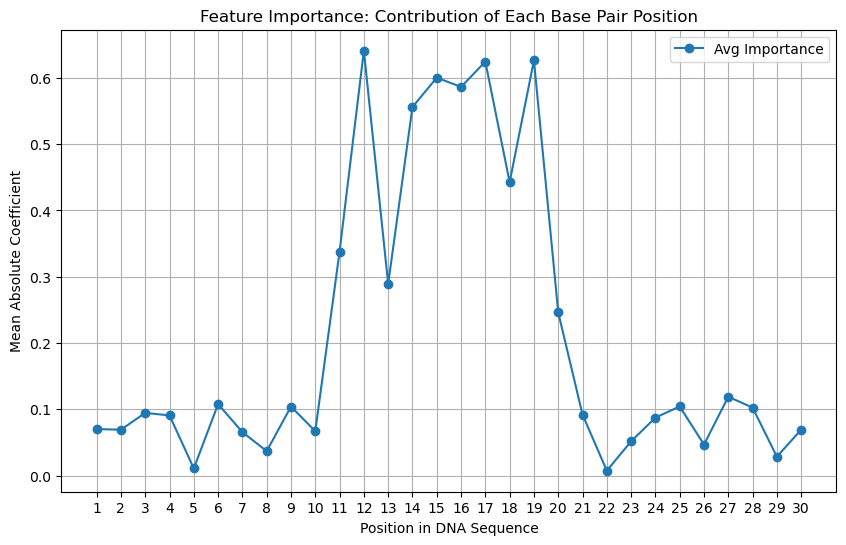

In [27]:
feature_importance_analysis(model)